## Prepare the grades for comments

In [54]:
import pandas as pd

In [55]:
path = '../other_dumps/comments'

In [56]:
# open the file where we'll add the final decision about comments
df_with_comments = pd.read_csv(f'{path}/VER2_all_comments_to_theories_with_scores.csv')
df_with_comments.head()

,id,status,thread,text,time,content_link,block_name,enabled,abuses,likes,replies,anon_user_id,area,step_id,topic_id,lemmatized_comments,count_bad,TextBlobPolarity,FlairPolarity,VaderPolarity
0,9403,fixed,comment,"""...to divide between two your friends""\r\nI t...",2019-06-08 20:14:45,https://hyperskill.org/learn/step/5614,text,0,0,0,0,45,math,5614,370.0,""" ... to divide between two your friend "" \r\n...",0,0.000000,0.817580,0.7351
1,9408,won't fix,comment,"It was not completely clear for me, how to con...",2019-06-08 20:32:26,https://hyperskill.org/learn/step/5614,text,1,0,3,2,45,math,5614,370.0,"it be not completely clear for I , how to conv...",3,0.065278,-0.999997,0.6766
2,15054,fixed,feedback,completly not understood,2019-07-09 11:11:43,https://hyperskill.org/learn/step/5753,text,1,0,0,0,105,math,5753,385.0,completly not understand,1,0.000000,-0.999818,0.0000
3,15115,fixed,feedback,A better explanation is needed with clear defi...,2019-07-09 17:34:21,https://hyperskill.org/learn/step/5753,text,1,0,0,0,109,math,5753,385.0,a well explanation be need with clear definiti...,4,0.300000,0.765204,0.6705
4,15268,fixed,comment,>remember that 2^8 in decimal is 1000 0000 in ...,2019-07-10 16:03:41,https://hyperskill.org/learn/step/5753,text,0,0,1,0,122,math,5753,385.0,> remember that 2 ^ 8 in decimal be 1000 0000 ...,0,0.000000,-0.999927,0.0258


In [ ]:
df_with_polarities = pd.read_csv(f'{path}/all_comments_to_theories_with_3_polarities.csv')

In [ ]:
# add polarities to the file with counts of bad words
df_with_comments['TextBlobPolarity'] = df_with_polarities.TextBlobPolarity
df_with_comments['FlairPolarity'] = df_with_polarities.FlairPolarity
df_with_comments['VaderPolarity'] = df_with_polarities.VaderPolarity
df_with_comments.head()

In [ ]:
# check their distributions again
# for Vader and TextBlob we can use the threshold 0.5
# and for Flair we'll use 0.75

<AxesSubplot:>

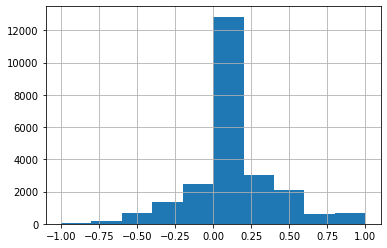

In [8]:
df_with_comments.TextBlobPolarity.hist()

<AxesSubplot:>

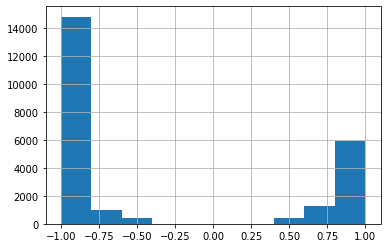

In [9]:
df_with_comments.FlairPolarity.hist()

<AxesSubplot:>

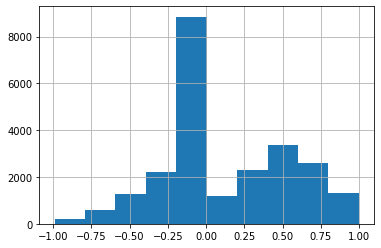

In [10]:
df_with_comments.VaderPolarity.hist()

In [19]:
def get_score_from_three(blob, flair, vader, blob_thrshld=0.5, flair_thrshld=0.75, vader_thrshld=0.5):
    """
    If two out of the three are positive/negative --> the comment is good/bad.
    Otherwise it's neutral. The function returns 1 for good, 0 for neutral, and -1 for bad.
    """
    list_more_thrshld = [el >= thrshld for el, thrshld in zip([blob, flair, vader], 
                                                              [blob_thrshld, flair_thrshld, vader_thrshld])]
    list_less_thrshld = [el <= -thrshld for el, thrshld in zip([blob, flair, vader], 
                                                               [blob_thrshld, flair_thrshld, vader_thrshld])]
    if sum(list_more_thrshld) >= 2:
        return 1
    elif sum(list_less_thrshld) >= 2:
        return -1
    else:
        return 0

<AxesSubplot:>

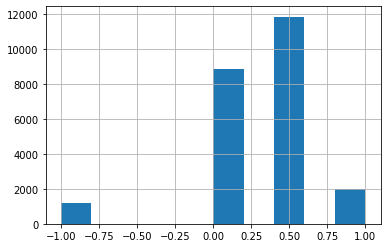

In [20]:
grades = []

for i, row in df_with_comments.iterrows():
    if row.count_bad == 0:  # if there are no suspicious words in the comment, we mark it separately
        grades.append(0.5)
        continue
    
    blob = row.TextBlobPolarity
    flair = row.FlairPolarity
    vader = row.VaderPolarity
    
    common_decision = get_score_from_three(blob, flair, vader)
    grades.append(common_decision)
    
df_with_comments['comment_grades'] = grades
df_with_comments.comment_grades.hist()

In [22]:
bad_read_comments = df_with_comments[df_with_comments.comment_grades == -1]
vague_read_comments = df_with_comments[df_with_comments.comment_grades == 0]
good_read_comments = df_with_comments[df_with_comments.comment_grades == 1]
no_triggers_comments = df_with_comments[df_with_comments.comment_grades == 0.5]

In [25]:
print(vague_read_comments.shape[0])
print(good_read_comments.shape[0])
print(no_triggers_comments.shape[0])

8877
1984
11866


In [23]:
print(bad_read_comments.shape[0])
bad_read_comments_non_fixed = bad_read_comments.drop(bad_read_comments[bad_read_comments.status == 'fixed'].index)
bad_read_comments_non_fixed.shape[0]  # delete those that were fixed (82 were deleted)

1178


1096

In [21]:
df_with_comments.to_csv(f'{path}/VER2_all_comments_to_theories_with_scores.csv', index=False)

## Get topics' division from comments' grades

What we'll do:

* topics that have >= THRESHOLD 'good' comments and no 'bad' comments: GOOD
* vice versa: BAD 
* topics that have no trigger words in comments: GOOD

As a result, many topics will end up in the 'vague' part but at least we'll be sure.

In [26]:
def count_good_and_bad_comments_per_each_topic(df):
    bad_comments_count_for_topics = dict()
    good_comments_count_for_topics = dict()

    for i, row in df.iterrows():
        status = row['status']
        comment_grade = row['comment_grades']
        topic_id = row['topic_id']

        # add the bad comments count
        if topic_id in bad_comments_count_for_topics:
            if comment_grade == -1 and status != 'fixed':
                bad_comments_count_for_topics[topic_id] += 1
            else:
                pass  # topic is in the dict but this comment is not bad so we don't change the count

        else:
            if comment_grade == -1 and status != 'fixed':
                bad_comments_count_for_topics[topic_id] = 1  # this is the first comment for topic and it's bad
            else:
                bad_comments_count_for_topics[topic_id] = 0  # this is the first comment for topic and it's not bad

        # now add the good comments count
        if topic_id in good_comments_count_for_topics:
            if comment_grade == 1:
                good_comments_count_for_topics[topic_id] += 1
            else:
                pass 
        else:
            if comment_grade == 1:
                good_comments_count_for_topics[topic_id] = 1  
            else:
                good_comments_count_for_topics[topic_id] = 0 
                
    return bad_comments_count_for_topics, good_comments_count_for_topics

In [27]:
bad_comments_count_for_topics, good_comments_count_for_topics = count_good_and_bad_comments_per_each_topic(df_with_comments)

In [28]:
def divide_into_good_vague_bad(bad_comments_count_for_topics, good_comments_count_for_topics, threshold):
    final_good_topics = []
    final_bad_topics = []
    final_vague_topics = []

    for topic_id in bad_comments_count_for_topics:
        bad_num = bad_comments_count_for_topics[topic_id]
        good_num = good_comments_count_for_topics[topic_id]

        if bad_num >= threshold and good_num == 0:
            final_bad_topics.append(topic_id)
        elif good_num >= threshold and bad_num == 0:
            final_good_topics.append(topic_id)
        else:
            final_vague_topics.append(topic_id)
            
    return final_good_topics, final_vague_topics, final_bad_topics

In [29]:
final_good_topics, final_vague_topics, final_bad_topics = divide_into_good_vague_bad(bad_comments_count_for_topics, 
                                                                                     good_comments_count_for_topics, 
                                                                                     threshold=2)

In [30]:
print('good dataset', len(final_good_topics))
print('bad dataset', len(final_bad_topics))
print('vague dataset', len(final_vague_topics))

good dataset 105
bad dataset 62
vague dataset 953


In [31]:
final_good_topics, final_vague_topics, final_bad_topics = divide_into_good_vague_bad(bad_comments_count_for_topics, 
                                                                                     good_comments_count_for_topics, 
                                                                                     threshold=1)

In [32]:
print('good dataset', len(final_good_topics))
print('bad dataset', len(final_bad_topics))
print('vague dataset', len(final_vague_topics))

good dataset 261
bad dataset 153
vague dataset 706


## Check the division of the topics with high likes and extend the corpus

In [38]:
import pickle

In [33]:
file = '/home/anna/Documents/Diploma/topics_with_statistics/topics_3_months_with_statistics_and_scores.csv'

In [34]:
topic_statistics = pd.read_csv(file)

In [35]:
# df with topcis where we can trust likes (with >20 evaluations)
more_likes = topic_statistics[topic_statistics.last_3_month_likes_count > 20]
more_likes.shape[0]

591

In [36]:
# df with topics with very high likes
very_good_topics = more_likes[more_likes.last_3_month_avg_like > 1.85]

In [37]:
# a list of steps from the dataframe
good_like_steps = [row['step_id'] for i, row in very_good_topics.iterrows()]

In [39]:
step_id_topic_id_mapping = pickle.load(open('step_id_topic_id_mapping.pkl', 'br'))

In [40]:
# a list of the corresponding topics from the dataframe
good_like_topics = set([step_id_topic_id_mapping[step_id] for step_id in good_like_steps])

In [42]:
intersected_good_like_bad_comments = good_like_topics.intersection(final_bad_topics)
print(len(intersected_good_like_bad_comments)) 
# 17 topics with the very high like ended up in the 'bad' topics list!

17


In [43]:
intersected_good_like_bad_comments  # 10 of them were in the previous VER1

{429.0,
 431.0,
 460.0,
 511.0,
 530.0,
 555.0,
 662.0,
 686.0,
 706.0,
 853.0,
 949.0,
 998.0,
 1071.0,
 1199.0,
 1342.0,
 1600.0,
 1849.0}

In [44]:
topic_id_step_id_mapping = pickle.load(open('topic_id_step_id_mapping.pkl', 'br'))

In [46]:
step_ids = [topic_id_step_id_mapping[topic_id] for topic_id in intersected_good_like_bad_comments]

In [48]:
# delete from 'bad' those that received good like
final_bad_topics = set(final_bad_topics) - intersected_good_like_bad_comments

# add to 'good' those that received good like
expanded_good_topics = good_like_topics.union(final_good_topics)

In [49]:
print(len(final_bad_topics), len(expanded_good_topics))  # VER1: 132 335

136 351


In [50]:
df_with_features = pd.DataFrame({'topic_id': list([int(el) for el in expanded_good_topics]) +\
                                 list([int(el) for el in final_bad_topics]), 
                                'target': [0] * len(expanded_good_topics) + [1] * len(final_bad_topics)})

In [52]:
path = './new_cleaned/train_corpus/target_features'
df_with_features.to_csv(f'{path}/topic_ids_with_target_features_VER2.csv', index=False)